# Load Spotify Data

Create a Spotify Developer Account and generate a Client ID & Secret Key. 

For the first step, we have created a public playlist with random songs.

In [1]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import plotly.express as px

load_dotenv()
# test
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials())

In [4]:
results = sp.playlist_items('5Rh7ikX5dteMXfc8tmeBJy')

song_ids = map(lambda song : song['track']['id'], results['items'])

features = sp.audio_features(song_ids)

raw_data = [{**song, 'features': features} for song, features in zip(results['items'], features)]

HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1uvyZBs4IZYRebHIB1747m,3S2R0EVwBSAVMd5UMgKTL0,2374M0fQpWi3dLnB54qaLX,4RvWPyQ5RL0ao9LPZeSouE,2MuWTIM3b0YEAskbeeFE1i,2fuCquhmrzHpu5xcA1ci9x,2WfaOiMkCvy7F5fcp2zZ8L,37ZJ0p5Jm13JPevGcx4SkF,77NNZQSqzLNqh2A9JhLRkg,4N0fzRX3T7QkOecp3pkWpp,4CeeEOM32jQcH3eN9Q2dGj,6MdqqkQ8sSC0WB4i8PyRuQ,4r8lRYnoOGdEi6YyI5OC1o,57bgtoPSgt236HzfBOd8kj,47BBI51FKFwOMlIiX6m8ya,0hrBpAOgrt8RXigk83LLNE,1Jaah2tmN9Hv81A87KZ1MU,1qPbGZqppFwLwcBC1JQ6Vr,1WYEDcS7WGjv0rG7rmMX3o,7H6ev70Weq6DdpZyyTmUXk,1QV6tiMFM6fSOKOGLMHYYg,3DQVgcqaP3iSMbaKsd57l5,5VGlqQANWDKJFl0MBG3sg2,0KQx6HOpJueiSkztcS0r7D,3TCauNPqFiniaYHBvEVoHG,7IdFdRlCjUi6kkhbPoRfnw,1vxw6aYJls2oq3gW0DujAo,1ixbwbeBi5ufN4noUKmW5a,3dPQuX8Gs42Y7b454ybpMR,1L5tZi0izXsi5Kk5OJf4W0,4OSBTYWVwsQhGLF9NHvIbR,3iVcZ5G6tvkXZkZKlMpIUs,3DK6m7It6Pw857FcQftMds,3e9HZxeyfWwjeyPAMmWSSQ,58q2HKrzhC3ozto2nDdN4z,4SDWMFvYJKtK1QPhIOeZhd,0wwPcA6wtMf6HUMpIRdeP7,0F7FA14euOIX8KcbEturGH,2VxeLyX666F8uXCJ0dZF8B,2Foc5Q5nqNiosCNqttzHof,3z8h0TU7ReD

SpotifyException: http status: 403, code:-1 - https://api.spotify.com/v1/audio-features/?ids=1uvyZBs4IZYRebHIB1747m,3S2R0EVwBSAVMd5UMgKTL0,2374M0fQpWi3dLnB54qaLX,4RvWPyQ5RL0ao9LPZeSouE,2MuWTIM3b0YEAskbeeFE1i,2fuCquhmrzHpu5xcA1ci9x,2WfaOiMkCvy7F5fcp2zZ8L,37ZJ0p5Jm13JPevGcx4SkF,77NNZQSqzLNqh2A9JhLRkg,4N0fzRX3T7QkOecp3pkWpp,4CeeEOM32jQcH3eN9Q2dGj,6MdqqkQ8sSC0WB4i8PyRuQ,4r8lRYnoOGdEi6YyI5OC1o,57bgtoPSgt236HzfBOd8kj,47BBI51FKFwOMlIiX6m8ya,0hrBpAOgrt8RXigk83LLNE,1Jaah2tmN9Hv81A87KZ1MU,1qPbGZqppFwLwcBC1JQ6Vr,1WYEDcS7WGjv0rG7rmMX3o,7H6ev70Weq6DdpZyyTmUXk,1QV6tiMFM6fSOKOGLMHYYg,3DQVgcqaP3iSMbaKsd57l5,5VGlqQANWDKJFl0MBG3sg2,0KQx6HOpJueiSkztcS0r7D,3TCauNPqFiniaYHBvEVoHG,7IdFdRlCjUi6kkhbPoRfnw,1vxw6aYJls2oq3gW0DujAo,1ixbwbeBi5ufN4noUKmW5a,3dPQuX8Gs42Y7b454ybpMR,1L5tZi0izXsi5Kk5OJf4W0,4OSBTYWVwsQhGLF9NHvIbR,3iVcZ5G6tvkXZkZKlMpIUs,3DK6m7It6Pw857FcQftMds,3e9HZxeyfWwjeyPAMmWSSQ,58q2HKrzhC3ozto2nDdN4z,4SDWMFvYJKtK1QPhIOeZhd,0wwPcA6wtMf6HUMpIRdeP7,0F7FA14euOIX8KcbEturGH,2VxeLyX666F8uXCJ0dZF8B,2Foc5Q5nqNiosCNqttzHof,3z8h0TU7ReDPLIbEnYhWZb,4UDmDIqJIbrW0hMBQMFOsM,5CQ30WqJwcep0pYcV4AMNc,0GjEhVFGZW8afUYGChu3Rr,0ofHAoxe9vBkTCp2UQIavz,4xHWH1jwV5j4mBYRhxPbwZ,40riOy7x9W7GXjyGp4pjAv,4N0TP4Rmj6QQezWV88ARNJ,2grjqo0Frpf2okIBiifQKs,2SpEHTbUuebeLkgs9QB7Ue,2IJftBfq7pJ43tfnOR0RB3,0DfG1ltJnZyq4Tx3ZLL7ZU,5vZ4IeUenK2cHub2d7yfWk,3NIDOSThELMihLSOMZcL4k,5LH1z4ma2TN2aVeESXthj9,228BxWXUYQPJrJYHDLOHkj,6mICuAdrwEjh6Y6lroV2Kg,5w9c2J52mkdntKOmRLeM2m,4sCSUQnWQ6HJsOMjfPicdn,3i3fYhl23l7exbIj9oAJPN,1MqzIgGsHP4cNjPboevsfq,34dx8DACTJsc3rsJdaEIQw,6RU0eIObzPf9HxYYV2hh5G,2d8D7uk3tbAThjRkdfrx9c,6IRA4KOVbtiGiTdYoEThJN,7sXTcibuNYugjjYNfgf2kY,2S7RApTsKT0CtYojYq2cKz,776AftMmFFAWUIEAb3lHhw,5zyrEv4F3FaLECI8TOKpFM,0jLeyuu6mtsD384054xLah,1vePC77pxGSUXLErDHuGtH,5Tbpp3OLLClPJF8t1DmrFD,5n8Aro6j1bEGIy7Tpo7FV7,7MJQ9Nfxzh8LPZ9e9u68Fq,7iL6o9tox1zgHpKUfh9vuC,0cGG2EouYCEEC3xfa0tDFV,39lSeqnyjZJejRuaREfyLL,4OdhffpvG3HxDJMxYOKh97,0qi4b1l0eT3jpzeNHeFXDT,3L7RtEcu1Hw3OXrpnthngx,7ACxUo21jtTHzy7ZEV56vU,78lgmZwycJ3nzsdgmPPGNx,5sICkBXVmaCQk5aISGR3x1,3CIOopLwvyMvXk97ZEksKO,54yLLvpezvPO1lA3GspiZj,0WtDGnWL2KrMCk0mI1Gpwz,0FZvjrHpAmLKj574M4VwrF,3NWTRZ0A8xKlBP1qgNftql,6g0Orsxv6glTJCt4cHsRsQ,4pAl7FkDMNBsjykPXo91B3,2YWjW3wwQIBLNhxWKBQd16,7BKLCZ1jbUBVqRi2FVlTVw,5knuzwU65gJK7IF5yJsuaW,0TDLuuLlV54CkRRUOahJb4,0nrRP2bk19rLc0orkWPQk2,1hwJKpe0BPUsq6UUrwBWTw,6md4w95cnKaW64JyEQ3A0L,60a0Rd6pjrkxjPbaKzXjfq,6qa36OkEeQqGaWlOcpjlGD,3Fcfwhm8oRrBvBZ8KGhtea:
 None, reason: None

Then extract all interesting / relevant data

In [ ]:
df = pd.DataFrame(columns=['id', 'name', 'artist', 'album', 'release_year', 'explicit', 'popularity', 'duration', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence'])

for idx, item in enumerate(raw_data):
    track = item['track']
    features = item['features']

    features = sp.audio_features(track["id"])
    track_features = features[0]

    data.append([
        track["id"],                        # string
        track["name"],                      # string
        track['artists'][0]['name'],        # string
        track['album']['name'],             # string
        track["popularity"],                # integer  0-100  % (current trendiness)
        track["duration_ms"],               # integer
        track_features["acousticness"],     # float    0-1    probability (whether the track uses instrumental rather than electric sounds)
        track_features["danceability"],     # float    0-1    probability (suitability for dancing)
        track_features["energy"],           # float    0-1    % (intensity / activity)
        track_features["instrumentalness"], # float    0-1    probability (whether the track contains no vocals)
        track_features["key"],              # integer  -1-11  (-1: none identified, 0: C, ...)
        track_features["liveness"],         # float    0-1    probability (whether the song is a live performance)
        track_features["loudness"],         # float           dB
        track_features["mode"],             # integer  0,1    (0: minor or 1: major)
        track_features["speechiness"],      # float    0-1    % (how many words are spoken rather than sang)
        track_features["tempo"],            # float           BPM
        track_features["time_signature"],   # integer  3-7    time signature (x/4, example: 3/4)
        track_features["valence"],          # float    0-1    spectrum (0: sad / angry, 1: happy)
        # TODO add explicit
        # TODO add release year
    ])

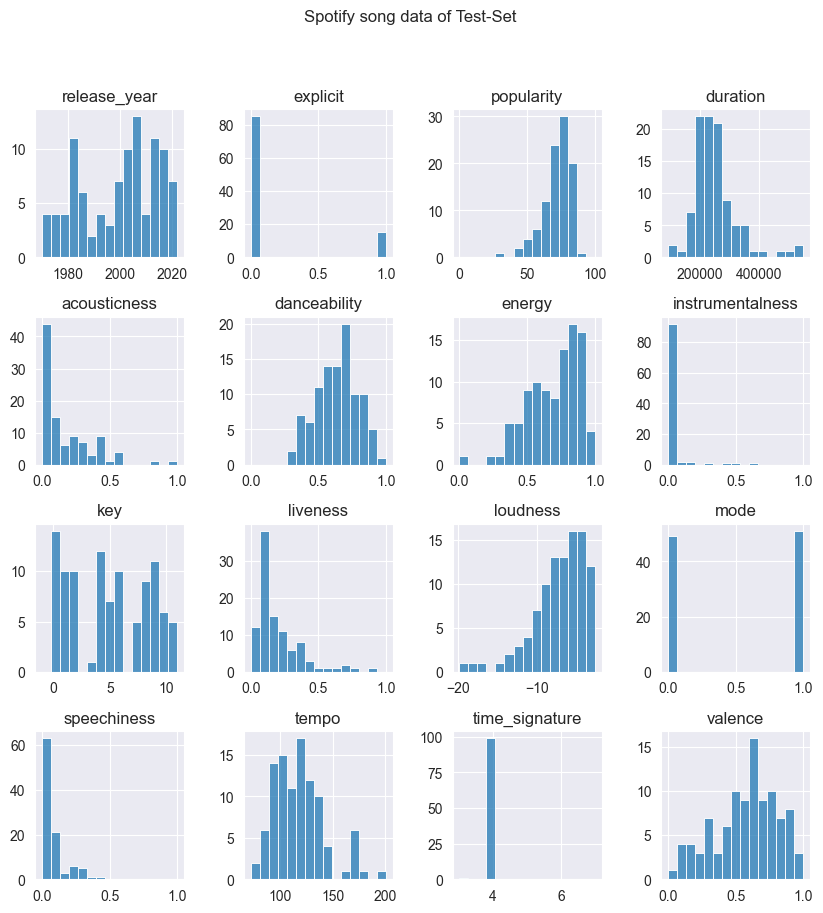

In [5]:
columns = [
    'release_year',
    'explicit',
    'popularity',
    'duration',
    'acousticness',
    'danceability',
    'energy',
    'instrumentalness',
    'key',
    'liveness',
    'loudness',
    'mode',
    'speechiness',
    'tempo',
    'time_signature',
    'valence',
]

x_ranges = [
    [],
    [0, 1],
    [0, 100],
    [],
    [0, 1],
    [0, 1],
    [0, 1],
    [0, 1],
    [-1, 11],
    [0, 1],
    [],
    [0, 1],
    [0, 1],
    [],
    [3, 7],
    [0, 1],
]

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

for i, column in enumerate(columns):
    ax = axes[i // 4, i % 4]

    data = df[column]
    x_range = x_ranges[i]
    
    data_range = None
    if len(x_range) == 2:
        data_range = [x_range[0], x_range[1]]

    sns.histplot(data, bins=15, ax=ax, binrange=data_range)
    ax.set_title(column)
    ax.set_xlabel('')
    ax.set_ylabel('')

#axes[3, 2].axis('off')
#axes[3, 3].axis('off')

plt.suptitle('Spotify song data of Test-Set')

plt.show()

# Which features do we need?

## Popularity
- **<span color='#e74c3c'>irrelevant</span>**
- **<span color='#e67e22'>probably irrelevant</span>**
- **<span color='#f1c40f'>maybe important</span>**
- **<span color='#2ecc71'>important</span>**

## Instrumentalness
- **<span color='#e67e22'>probably irrelevant</span>**

In [ ]:
purged = df.drop([
    'popularity',
    'duration',
    'instrumentalness',
    'liveness',
    'time_signature',
], axis='columns')

print(updated.columns)

In [4]:
df.head()

,id,name,artist,album,popularity,duration,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,1uvyZBs4IZYRebHIB1747m,Purple Rain,Prince,Purple Rain,72,521866,0.035400,0.373,0.452,0.002270,10,0.6890,-10.417,1,0.0321,113.212,4,0.179
1,3S2R0EVwBSAVMd5UMgKTL0,Thriller,Michael Jackson,Thriller 25 Super Deluxe Edition,78,357266,0.085500,0.773,0.859,0.000187,11,0.9140,-4.913,1,0.0747,118.459,4,0.813
2,2374M0fQpWi3dLnB54qaLX,Africa,TOTO,Toto IV,84,295893,0.257000,0.671,0.373,0.000080,9,0.0481,-18.064,1,0.0323,92.718,4,0.732
3,4RvWPyQ5RL0ao9LPZeSouE,Everybody Wants To Rule The World,Tears For Fears,Songs From The Big Chair (Super Deluxe Edition),85,251488,0.347000,0.645,0.795,0.003890,7,0.1040,-12.095,1,0.0527,112.067,4,0.535
4,2MuWTIM3b0YEAskbeeFE1i,Master Of Puppets,Metallica,Master Of Puppets (Remastered),75,515386,0.000647,0.543,0.836,0.431000,4,0.1530,-9.110,0,0.0353,105.173,4,0.560


In [6]:
df.count()

id                  100
name                100
artist              100
album               100
popularity          100
duration            100
acousticness        100
danceability        100
energy              100
instrumentalness    100
key                 100
liveness            100
loudness            100
mode                100
speechiness         100
tempo               100
time_signature      100
valence             100
dtype: int64

In [15]:
x = df[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'key', 'loudness', 'tempo', 'speechiness', 'valence']]
x

,acousticness,danceability,energy,instrumentalness,liveness,key,loudness,tempo,speechiness,valence
0,0.035400,0.373,0.452,0.002270,0.6890,10,-10.417,113.212,0.0321,0.179
1,0.085500,0.773,0.859,0.000187,0.9140,11,-4.913,118.459,0.0747,0.813
2,0.257000,0.671,0.373,0.000080,0.0481,9,-18.064,92.718,0.0323,0.732
3,0.347000,0.645,0.795,0.003890,0.1040,7,-12.095,112.067,0.0527,0.535
4,0.000647,0.543,0.836,0.431000,0.1530,4,-9.110,105.173,0.0353,0.560
...,...,...,...,...,...,...,...,...,...,...
95,0.003940,0.490,0.679,0.000015,0.0383,8,-3.680,167.046,0.0309,0.506
96,0.545000,0.862,0.515,0.000153,0.0899,0,-6.897,129.044,0.0368,0.696
97,0.009580,0.556,0.864,0.000000,0.2090,3,-5.870,105.143,0.0584,0.400
98,0.409000,0.343,0.985,0.001190,0.0517,6,-3.174,201.057,0.1380,0.724


In [16]:
from sklearn.preprocessing import StandardScaler

normalized_data = StandardScaler().fit_transform(x)
normalized_data

array([[-6.95493985e-01, -1.67850974e+00, -1.27447339e+00,
        -2.41809330e-01,  2.86696072e+00,  1.43252529e+00,
        -9.47230622e-01, -1.90928702e-01, -6.57389306e-01,
        -1.74324360e+00],
       [-4.37926555e-01,  9.05403037e-01,  8.84859673e-01,
        -2.64094496e-01,  4.19406074e+00,  1.71732157e+00,
         6.99570208e-01,  2.30096919e-02, -1.33406512e-01,
         1.02724319e+00],
       [ 4.43766344e-01,  2.46505279e-01, -1.69360683e+00,
        -2.65238176e-01, -9.13209966e-01,  1.14772901e+00,
        -3.23521862e+00, -1.02654018e+00, -6.54929293e-01,
         6.73285097e-01],
       [ 9.06462326e-01,  7.85509484e-02,  5.45308528e-01,
        -2.24477612e-01, -5.83499338e-01,  5.78136449e-01,
        -1.44928945e+00, -2.37614324e-01, -4.04007955e-01,
        -1.87575939e-01],
       [-8.74161468e-01, -5.80346810e-01,  7.62833480e-01,
         4.34499776e+00, -2.94486444e-01, -2.76252392e-01,
        -5.56175265e-01, -5.18706622e-01, -6.18029096e-01,
        -7.

In [20]:
from sklearn.cluster import KMeans
import numpy as np
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(x)
kmeans.labels_

# kmeans.predict([[0, 0], [12, 3]])
# kmeans.cluster_centers_

array([3, 0, 2, 3, 3, 3, 2, 0, 0, 3, 0, 2, 1, 4, 3, 2, 2, 1, 1, 4, 0, 3,
       4, 2, 2, 2, 3, 1, 0, 2, 3, 3, 2, 3, 4, 2, 4, 4, 2, 0, 4, 3, 2, 3,
       0, 0, 4, 3, 0, 3, 2, 1, 4, 2, 0, 2, 3, 2, 4, 4, 0, 0, 2, 0, 3, 3,
       0, 3, 0, 0, 3, 2, 3, 1, 2, 4, 0, 4, 0, 0, 4, 3, 0, 4, 2, 1, 0, 0,
       0, 3, 2, 2, 3, 0, 0, 1, 0, 3, 1, 4], dtype=int32)

In [29]:
dict_songs = {}
for i in range(n_clusters):
    dict_songs[i] = []

print(dict_songs)

for index, item in enumerate(kmeans.labels_):
    dict_songs[item].append(df.iloc[[index]].name)

dict_songs

{0: [], 1: [], 2: [], 3: [], 4: []}


{0: [1    Thriller
  Name: name, dtype: object,
  7    Livin' On A Prayer
  Name: name, dtype: object,
  8    Don't Stop Believin'
  Name: name, dtype: object,
  10    Smells Like Teen Spirit
  Name: name, dtype: object,
  20    Poker Face
  Name: name, dtype: object,
  28    Seven Nation Army
  Name: name, dtype: object,
  39    Get Lucky (Radio Edit) [feat. Pharrell William...
  Name: name, dtype: object,
  44    Dreams - 2004 Remaster
  Name: name, dtype: object,
  45    Time - 2011 Remastered Version
  Name: name, dtype: object,
  48    September
  Name: name, dtype: object,
  54    Ding
  Name: name, dtype: object,
  60    Tourner Dans Le Vide
  Name: name, dtype: object,
  61    Papaoutai
  Name: name, dtype: object,
  63    Voyage voyage
  Name: name, dtype: object,
  66    L'italiano
  Name: name, dtype: object,
  68    Nel Blu Dipinto Di Blu
  Name: name, dtype: object,
  69    Ciao Ciao
  Name: name, dtype: object,
  76    Hungry Like the Wolf - 2009 Remaster
  Name: name, dt

As we see, Spotify already develiver good quality data. So we don't need to do data assessments.